In this notebook I will extract the density of the taxa that might be in the active layer for a range of combinations of modeled backscatter responses 


In [1]:
import os
import numpy as np
import pandas as pd
from scipy import signal
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
import matplotlib
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import random
import pylab
import glob
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime
import cartopy.crs as ccrs
import cartopy
#from uncertainties import unumpy

import inverse_method_funs as inv
import sb_tools

%matplotlib inline

In [2]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

# Read scattering models
Import species backscattering cross section matrix

In [3]:
# Sigmabs from ZooScatR model runs + viscous elactic model for mean of fish larvae model by ve=True)
fname_sim = '../ZooScatStuff/my_simplified_data.feather'

specs, freqs_sim, sig_bs_mean, ci_boot = inv.read_scatteringmodelsimulations(fname_sim, nsim=1000, ve=True)

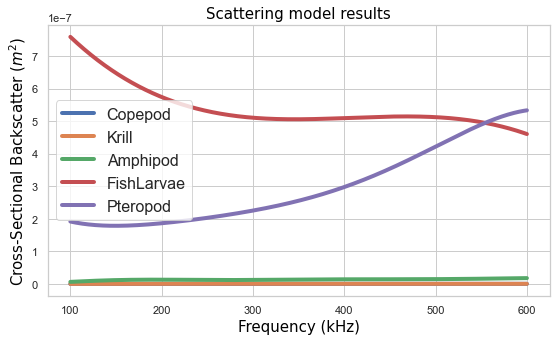

In [4]:
fig=plt.figure(figsize=(9, 5),facecolor='w', edgecolor='k')
plt.plot(freqs_sim,sig_bs_mean, linewidth=4)
plt.legend(specs, fontsize=16)
plt.ylabel('Cross-Sectional Backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

# Resample to line up output and input

In [5]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/Flaket_SSL/*_ssl.csv')

sv_all = np.zeros((1001,0))
times = np.zeros((0))

freqs_EV, sv_out_no, times_out_no = inv.read_widebandfrequencyresponse(fname_EV[0])
sv_all = np.zeros((len(freqs_EV),0))
times = np.zeros((0))

In [6]:
len(freqs_EV)

1001

In [7]:
sigbs_mean = np.zeros([len(freqs_EV),len(specs)])
ci_boot0 = np.zeros([len(freqs_EV),len(specs)])
ci_boot1 = np.zeros([len(freqs_EV),len(specs)])


for ind_spec in range(0,len(specs)):
    sigbs_mean[:,ind_spec] = np.interp(freqs_EV, freqs_sim, sig_bs_mean[:,ind_spec])
    ci_boot0[:,ind_spec] = np.interp(freqs_EV, freqs_sim, ci_boot[0,:,ind_spec])
    ci_boot1[:,ind_spec] = np.interp(freqs_EV, freqs_sim, ci_boot[1,:,ind_spec])

In [8]:
np.shape(sigbs_mean)

(1001, 5)

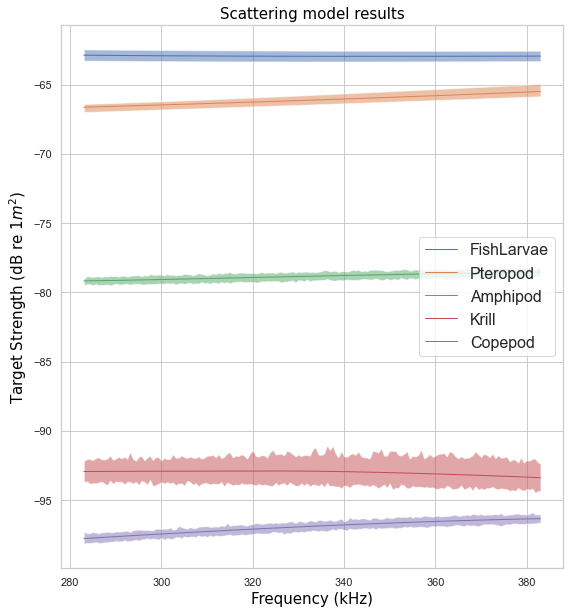

In [8]:
fig=plt.figure(figsize=(9, 10),facecolor='w', edgecolor='k')
order=[3,4,2,1,0]
for ind in [3,4,2,1,0]:
    # Calculate log ci S(TS) = 10*0.434(S(sigbs)/sigbs)
    logci_0 = 10*np.log10(sigbs_mean[:,ind]) - (10*(0.434*(sigbs_mean[:,ind]-ci_boot0[:,ind])/sigbs_mean[:,ind]))
    logci_1 = 10*np.log10(sigbs_mean[:,ind]) + 10*(0.434*(ci_boot1[:,ind]-sigbs_mean[:,ind])/sigbs_mean[:,ind])
    
    plt.plot(freqs_EV[:],10*np.log10(sigbs_mean[:,ind]), linewidth=1, label=specs[ind])
    plt.fill_between(freqs_EV[:],logci_0,logci_1, alpha=0.5)
    
plt.legend(fontsize=16, loc='right')
plt.ylabel('Target Strength (dB re $1m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

# Inverse method
Calculate mean predicted density for each active layer

# Sensitivity analysis
Make matrix with ci_min, mean and ci_max for all species



In [66]:
sensitvity_matrix = [ci_boot0, sigbs_mean, ci_boot1]

In [ ]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/Flaket_SSL/*_ssl.csv')
nfiles = len(fname_EV)

# sensitivitiy analysis iterations
# 5 digits with 3 values each has 150 permutations
n_iterations = 150

sensitvity_sig = np.zeros((np.shape(sigbs_mean)))
sv_all = np.zeros((len(freqs_EV),0))
times = np.zeros((0))
density = np.zeros((n_iterations, 5, nfiles))


for iterate in np.arange(n_iterations):
    for ind in range(len(specs)):
        rand_ind = np.random.randint(0,2)
        sensitvity_sig[:,ind] = sensitvity_matrix[rand_ind][:,ind]
        
    for ind in np.arange(nfiles):
        freqs_EV, sv_out, times_out = inv.read_widebandfrequencyresponse(fname_EV[ind])
        sv_mean = np.mean(sv_out,1)
        sv_std = np.mean(sv_out,1)

        times = np.append(times, times_out[0])

        d = optimize.lsq_linear(sensitvity_sig, sv_mean, bounds=(0,np.inf))
        density[iterate,:,ind] =  d.x
        #for spec_ind in np.arange(len(specs)):

            # try with unumpy
            #sv_u = unumpy.umatrix(sv_mean,sv_std)
            #sig_u = unumpy.umatrix(sigbs,ci_boot0)
            #sig_u1 = unumpy.umatrix(sigbs,ci_boot1)
            #density_mean_u = unumpy.nominal_values(sv_u*sig_u)
            #density_mean_u1 = unumpy.nominal_values(sv_u*sig_u1)
            #density_std_u = unumpy.std_devs(sv_u*sig_u)
            #density_std_u1 = unumpy.std_devs(sv_u*sig_u1)
            #density_std0[ind,spec_ind] = (sv_u*sig_u)
            #density_std1[ind,spec_ind] = (sv_u*sig_u1)

In [160]:
density[:,1,5]

array([  51.84782052, 1102.39067881,  108.7295577 ,  209.65923883,
        374.66295469,    3.04499133,  274.61325635,  374.66295469,
        204.18314127,   54.84960833,   54.84960833, 1182.65857723,
         36.20248378,  325.47621231,  109.08017924,  204.18314127,
        253.53014113,  149.65570353,   74.1046712 ,  129.13252893,
        209.65923883,  129.13252893, 1102.39067881,   74.1046712 ,
        313.30593805,  374.66295469,  325.47621231,   13.97921836,
        200.6101412 , 1122.96978408,  325.47621231,  253.53014113,
         50.85710581,  209.65923883,  204.18314127,  376.21828264,
        149.65570353,  313.30593805,  130.98870274,   54.84960833,
        423.90307826,   36.20248378,  423.90307826,  130.98870274,
       1203.77880735,  259.2057128 ,   50.85710581,  129.13252893,
        259.2057128 ,  109.08017924])

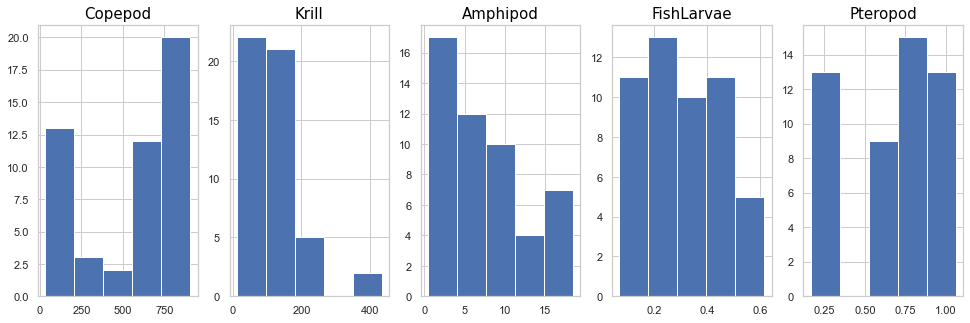

In [204]:
plt.figure(figsize=(20, 5),facecolor='w', edgecolor='k')
plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)
plt.xlabel('Functional group', axis_font)
for ind in range(0,len(specs)):
    plt.subplot(1,len(specs)+1,ind+1)
    plt.hist(density[:,ind,np.random.randint(67)], bins=5)
    plt.title(specs[ind], title_font)


## Load lat/lon

In [162]:
SB_env_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SB_env_tromsøflaket2018.xlsx',header=0, engine="openpyxl")


In [163]:
SB_env_times = SB_env_df.set_index(['datetime'])

In [164]:
index = []
for ind in range(len(times)):
    ind_index = SB_env_times.index.get_loc(times[ind], method="nearest")
    index = np.append(index, ind_index)

# Make dataframe

In [169]:
len(times)

3350

In [206]:
data = pd.DataFrame()

for specs_ind in range(len(specs)):
    for ind in range(nfiles):
        SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
        data = data.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            'density': density[np.random.randint(50),specs_ind,ind],
                            'species': specs[specs_ind],                        
                            'source': 'Acoustics'}, 
                            'ignore_index=True')

## Add net data

In [207]:
SP_stations_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SeaPatchesStations.xlsx',header=0)
tucker_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/Tucker Trawl.xlsx', header=79)
multinet_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SP_Multinet.xlsx')

In [208]:
#Station 7 from Tucker Trawl
stn = 7
for stn_ind in range(7,18):
    for ind_spec in [0,1,2,3,5]:
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': tucker_density['Station ' + str(stn_ind)][ind_spec],
                            'species': tucker_density['Species'][ind_spec],
                            'source': 'TuckerTrawl'}, 
                            'ignore_index=True')
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': multinet_density['Stn ' + str(stn_ind)][ind_spec],
                            'species': multinet_density['Species'][ind_spec],
                            'source': 'Multinet'}, 
                            'ignore_index=True')

In [209]:
## Add log of data as column
data['log_density']=np.log10(data.density+1)
data['log_density'][np.isnan(data['log_density'])]==0


Series([], Name: log_density, dtype: bool)

In [210]:
# save for use in another notebook
data.to_pickle("density_file.pkl")

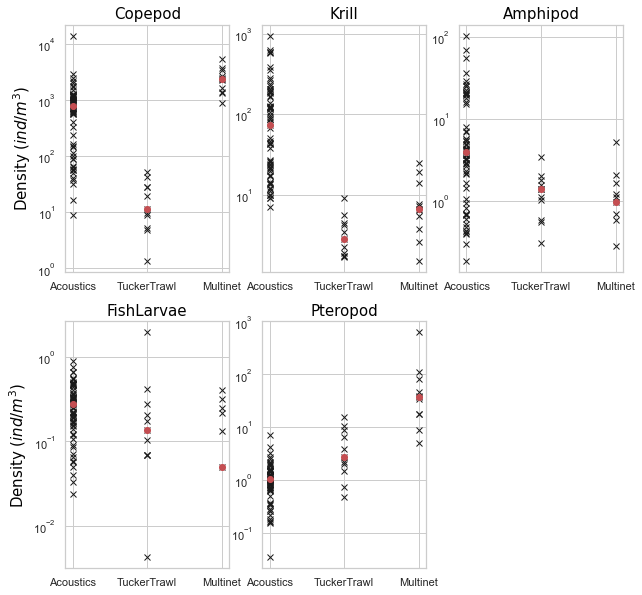

In [211]:
fig = plt.figure(figsize=(10,10))
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    ax.semilogy(data.source[data.species==specs[ind_spec]],data.density[data.species==specs[ind_spec]], 'kx')
    ax.semilogy(data[data.species==specs[ind_spec]].groupby('source').median().index,data[data.species==specs[ind_spec]].groupby('source').median()['density'], 'r.', markersize=12)
    ax.set_title(specs[ind_spec], title_font)
    if ind_spec==0:
        ax.set_ylabel('Density ($ind/m^3$)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('Density ($ind/m^3$)', axis_font);


In [212]:
len(data.density[data.source=='TuckerTrawl'])/5

11.0

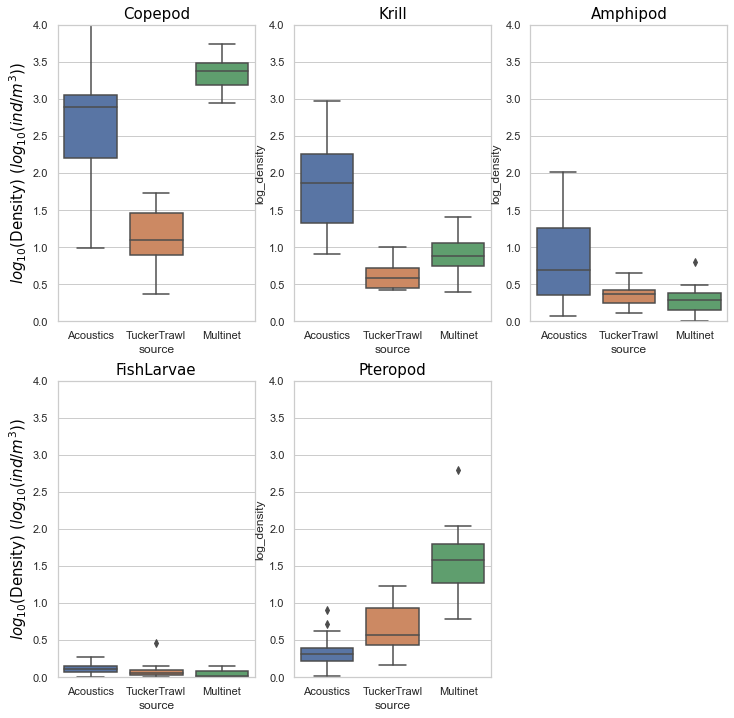

In [213]:
fig = plt.figure(figsize=(12,12))
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    splot = sns.boxplot(data = data[data.species==specs[ind_spec]], x='source', y='log_density')
    ax.set_title(specs[ind_spec], title_font)
    ax.set_ylim([0,4])
    if ind_spec==0:
        ax.set_ylabel('$log_{10}$(Density) ($log_{10}(ind/m^3)$)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('$log_{10}$(Density) ($log_{10}(ind/m^3)$)', axis_font);

Negative densities... Won't use violin plots here

# Set up per species data

In [26]:
data_spec = pd.DataFrame()

for ind in range(len(times)):
    specs_ind=0
    SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
    data_spec = data_spec.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            specs[specs_ind]: density[specs_ind, ind],
                            specs[specs_ind+1]: density[specs_ind+1, ind],
                            specs[specs_ind+2]: density[specs_ind+2, ind],
                            specs[specs_ind+3]: density[specs_ind+3, ind],
                            specs[specs_ind+4]: density[specs_ind+4, ind],
                            'source': 'Acoustic'}, 
                            'ignore_index=True')

In [52]:
#Dataframe with all species
for stn_ind in range(7,18):
    data_spec = data_spec.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                        'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                        'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                        tucker_density['Species'][0]: tucker_density['Station ' + str(stn_ind)][0],
                        tucker_density['Species'][1]: tucker_density['Station ' + str(stn_ind)][1],
                        tucker_density['Species'][2]: tucker_density['Station ' + str(stn_ind)][2],
                        tucker_density['Species'][3]: tucker_density['Station ' + str(stn_ind)][3],
                        tucker_density['Species'][5]: tucker_density['Station ' + str(stn_ind)][5],
                        'source': 'TuckerTrawl'}, 
                        'ignore_index=True')
    data_spec = data_spec.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                        'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                        'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                        multinet_density['Species'][0]: multinet_density['Stn ' + str(stn_ind)][0],
                        multinet_density['Species'][1]: multinet_density['Stn ' + str(stn_ind)][1],
                        multinet_density['Species'][2]: multinet_density['Stn ' + str(stn_ind)][2],
                        multinet_density['Species'][3]: multinet_density['Stn ' + str(stn_ind)][3],
                        multinet_density['Species'][5]: multinet_density['Stn ' + str(stn_ind)][5],
                        'source': 'Multinet'}, 
                        'ignore_index=True')

In [54]:
# Send to R
data.to_feather('.\SSL_density.feather')
data_spec.to_feather('.\SSL_density_spec.feather')